In [28]:
# Imports
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# EJ 1)

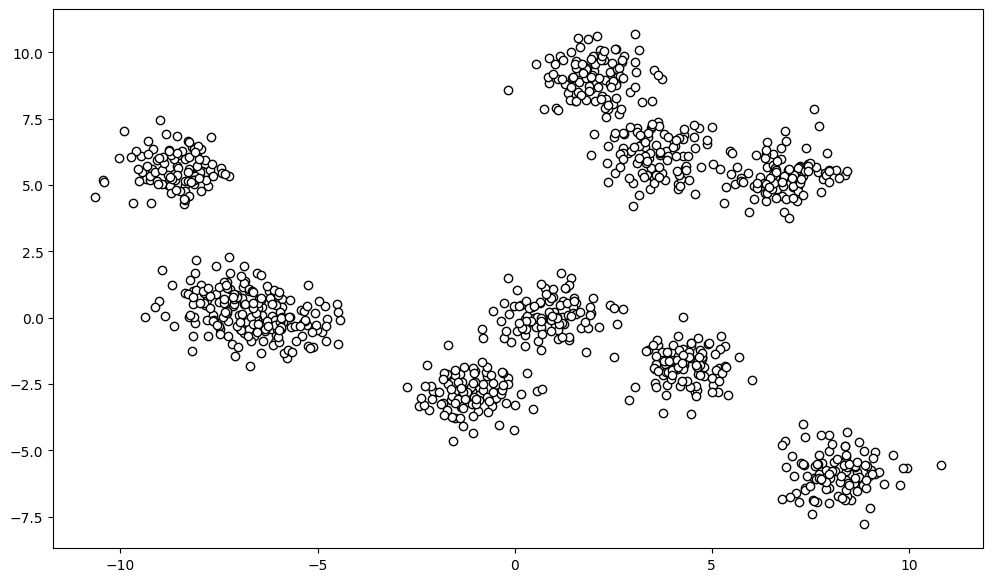

In [29]:
#plots
X, y = make_blobs(n_samples = 1000, n_features = 5, centers = 10, cluster_std = .70, random_state = 7)

# Representación gráfica incial (sólo las dos primeras dimensiones)
# %matplotlib inline
plt.figure(figsize=(12, 7))
plt.scatter(x = X[:, 0], y = X[:, 1], c = 'white', marker    = 'o',edgecolor = 'black')
plt.show()

In [30]:
#more imports
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import seaborn as sns
import holoviews as hv
import plotly.graph_objects as go
import kmedoids


## K-means

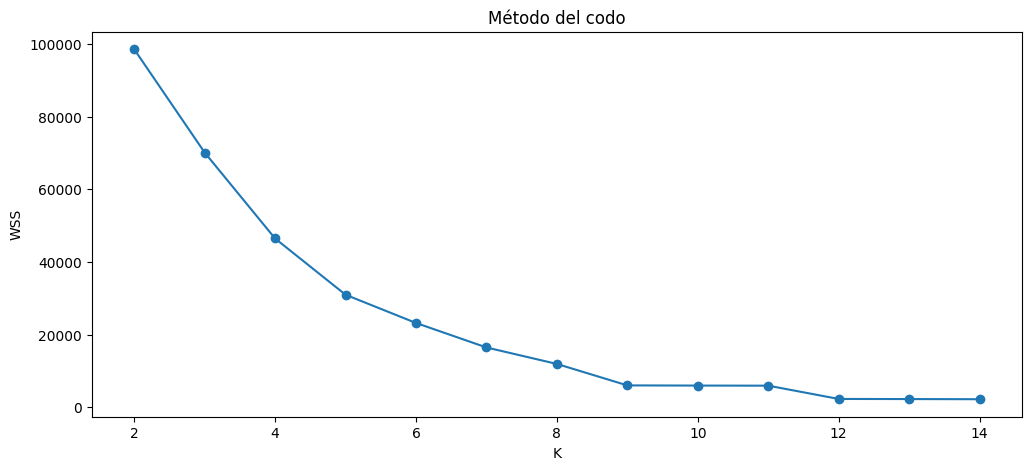

In [31]:
#escalado
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
#CODO

wss = []
rango_prueba = range(2, 15)
for K in rango_prueba:
    clf = KMeans(init="random", random_state=0, n_clusters=K)
    clf.fit(X)
    wss.append(clf.inertia_)

plt.figure(figsize=(12,5))
plt.plot(rango_prueba, wss, marker='o')
plt.xlabel("K")
plt.ylabel("WSS")
plt.title("Método del codo")
plt.show()


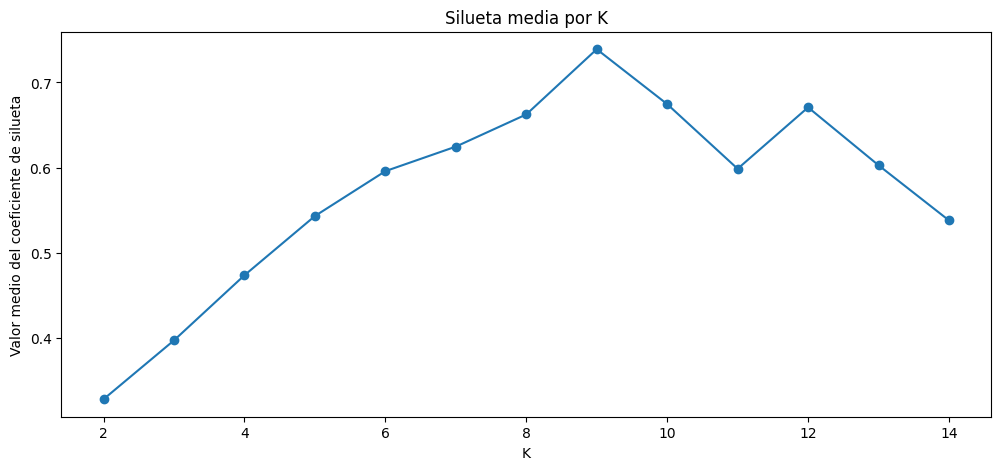

In [32]:
# cálculo de la silueta media
valores_silueta_media = []
rango_prueba = range(2, 15)
for K in rango_prueba:
    clf = KMeans(init="random", random_state=0, n_clusters=K)
    clf.fit(X)
    labels = clf.labels_  # etiquetas tras el ajuste
    silueta_media = silhouette_score(X, labels)
    valores_silueta_media.append(silueta_media)

# Represento la silueta media por K
plt.figure(figsize=(12,5))
plt.plot(rango_prueba, valores_silueta_media, marker='o')
plt.xlabel("K")
plt.ylabel("Valor medio del coeficiente de silueta")
plt.title("Silueta media por K")
plt.show()


Diria que coinciden todas las graficas en 9 k que es lo que se ve visualmente tambien.

In [33]:
clf = KMeans(init="random", random_state=0, n_clusters=9)
clf.fit(X)

import pandas as pd
dfXY = pd.DataFrame(X, columns=[f"feat_{i+1}" for i in range(X.shape[1])])
dfXY["target"] = y
dfXY["Cluster_asignado"] = clf.labels_

In [34]:
dfXY

,feat_1,feat_2,feat_3,feat_4,feat_5,target,Cluster_asignado
0,-8.392242,4.300712,-2.190717,4.981112,9.378969,0,3
1,1.637687,9.251373,-5.399325,1.402957,8.435388,4,6
2,-7.001162,0.118227,2.764019,2.924879,1.150445,5,4
3,-6.707356,-1.830469,-3.727419,0.199461,-3.091068,6,5
4,-5.363811,-0.198699,-2.568376,-0.703003,-2.617852,6,5
...,...,...,...,...,...,...,...
995,0.120446,-0.202572,-8.904928,-3.658238,0.223965,1,0
996,3.770414,-3.597693,8.622485,-6.159854,5.356647,9,1
997,-9.522146,5.140548,-2.069451,5.411706,9.776573,0,3
998,4.250706,-1.716770,8.567644,-6.096111,5.077266,9,1


Vemos la reasignacion de clusters que ha realizado, en el grafico es mas claro

<Axes: xlabel='Cluster_asignado'>

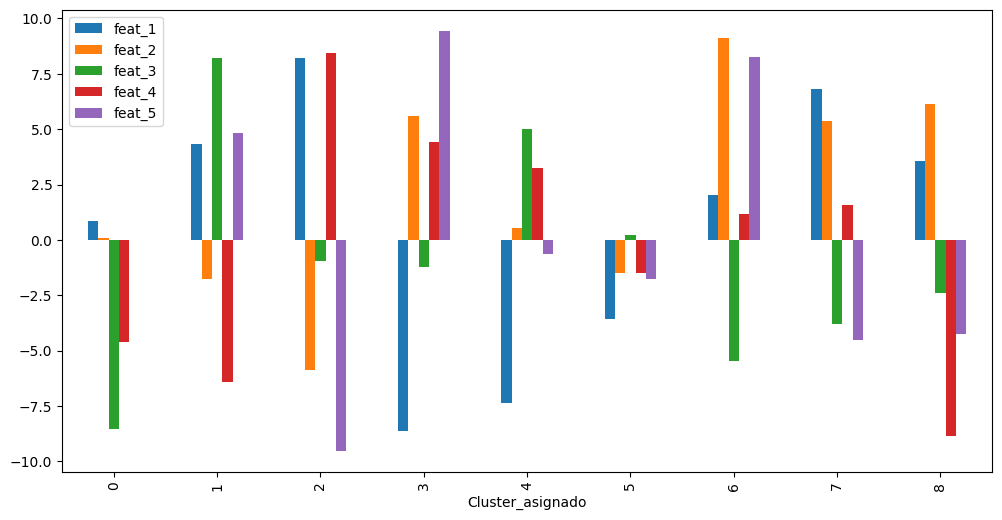

In [35]:
dfXY.drop(columns=["target"]).groupby('Cluster_asignado').mean().plot(kind='bar', figsize=(12,6))

## K-medoids

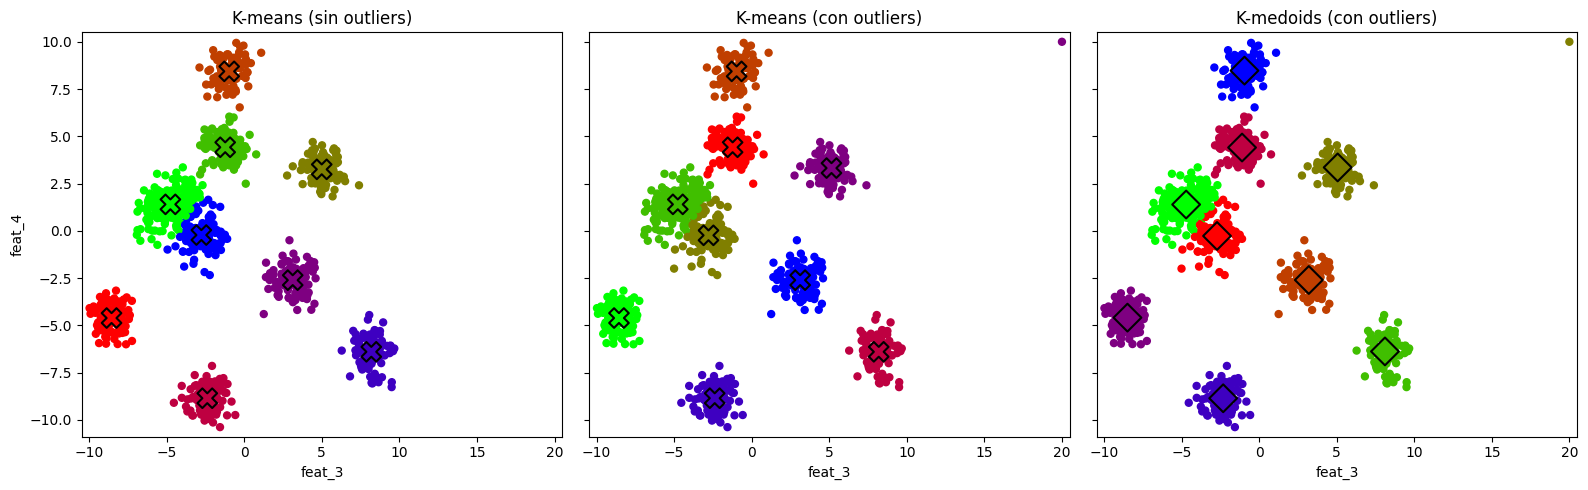

In [36]:
# 1) Tomamos dos features sin escalar
feat_idx = [2, 3]  # dos columnas de X (0-index)
X2 = X[:, feat_idx]
feature_names_2d = [f"feat_{i+1}" for i in feat_idx]

# 2) Añadimos dos outliers extremos
o1 = np.array([[20.0, 10.0]])
o2 = np.array([[-5.0, -2.0]])
X2_out = np.vstack([X2, o1, o2])

# 3) Creamos los modelos K-means con datos originales, K-means con outliers y K-medoids
K = 9
km_base = KMeans(n_clusters=K, init="random", random_state=0).fit(X2)
lab_km_base = km_base.labels_  # clúster asignado a cada punto

km_out = KMeans(n_clusters=K, init="random", random_state=0).fit(X2_out)
lab_km_out = km_out.labels_

kmed = kmedoids.KMedoids(
    n_clusters=K, method="fasterpam", metric="euclidean", random_state=0
).fit(X2_out)
lab_kmed = kmed.labels_

# 4) Visualización de los 3 casos a la vez:

# Rango común de ejes para los tres paneles
x_min = min(X2_out[:, 0].min(), X2[:, 0].min()) - 0.5
x_max = max(X2_out[:, 0].max(), X2[:, 0].max()) + 0.5
y_min = min(X2_out[:, 1].min(), X2[:, 1].min()) - 0.5
y_max = max(X2_out[:, 1].max(), X2[:, 1].max()) + 0.5

# Fijamos los colores a usar en los 3 casos
cmap = plt.colormaps['brg_r']

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)

# Panel 1: K-means sin outliers
ax = axes[0]
ax.scatter(X2[:, 0], X2[:, 1], c=lab_km_base, cmap=cmap, vmin=0, vmax=K-1, s=25)
cent_km_base = km_base.cluster_centers_
axes[0].scatter(
    cent_km_base[:, 0], cent_km_base[:, 1],
    c=np.arange(K), cmap=cmap, vmin=0, vmax=K-1,
    s=200, marker='X', edgecolors='k', linewidths=1.5, label='Centroide'
)
ax.set_title("K-means (sin outliers)")
ax.set_xlabel(feature_names_2d[0]); ax.set_ylabel(feature_names_2d[1])
ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max)

# Panel 2: K-means con outliers
ax = axes[1]
ax.scatter(X2_out[:, 0], X2_out[:, 1], c=lab_km_out, cmap=cmap, vmin=0, vmax=K-1, s=25)
cent_km_out = km_out.cluster_centers_
axes[1].scatter(
    cent_km_out[:, 0], cent_km_out[:, 1],
    c=np.arange(K), cmap=cmap, vmin=0, vmax=K-1,
    s=200, marker='X', edgecolors='k', linewidths=1.5, label='Centroide'
)
ax.set_title("K-means (con outliers)")
ax.set_xlabel(feature_names_2d[0])
ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max)

# Panel 3: K-medoids con outliers
ax = axes[2]
ax.scatter(X2_out[:, 0], X2_out[:, 1], c=lab_kmed, cmap=cmap, vmin=0, vmax=K-1, s=25)
medoids = kmed.cluster_centers_
axes[2].scatter(
    medoids[:, 0], medoids[:, 1],
    c=np.arange(K), cmap=cmap, vmin=0, vmax=K-1,
    s=200, marker='D', edgecolors='k', linewidths=1.5, label='Medoide'
)
ax.set_title("K-medoids (con outliers)")
ax.set_xlabel(feature_names_2d[0])
ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max)

%matplotlib inline
plt.tight_layout()
plt.show()


K-means cambia la posición de sus centroides cuando se añaden outliers, alterando los clústeres.
K-medoids mantiene sus grupos estables, mostrando mayor robustez frente a los valores extremos. Aunque no parece cambiar mucho en este caso.

## Aglomerativo

In [37]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import BisectingKMeans
from sklearn.metrics import silhouette_score
X_scaled = scaler.fit_transform(X)

In [38]:
def plot_dendrogram_from_sklearn(model, **kwargs):
    """
    Dado un modelo AgglomerativeClustering de scikit-learn, obtiene la 'linkage matrix'
    que requiere SciPy para dibujar el dendrograma y lo dibuja.
    Requiere: distance_threshold=0 y compute_distances=True en el modelo.
    """
    # Número de muestras originales:
    n_samples = len(model.labels_)
    counts = np.zeros(model.children_.shape[0])
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return dendrogram(linkage_matrix, **kwargs)


def _discrete_palette(n_classes: int, cmap_name: str = "tab10"):
    """
    Devuelve una paleta discreta de colores para un número dado de clases (`n_classes`).
    El mapa de colores se especifica mediante `cmap_name`. Si este es discreto y tiene
    suficientes colores predefinidos, se usan esos; si es continuo, se toman muestras equiespaciadas.
    """
    cmap = plt.colormaps.get(cmap_name)
    colors = getattr(cmap, "colors", None)
    if colors is not None and len(colors) >= n_classes:
        return np.array(colors[:n_classes])
    return cmap(np.linspace(0, 1, n_classes))

def pca_scatter_2d(X, labels=None, title="", palette="tab10", legend_title="Cluster"):
    """
    Proyecta datos con PCA a 2D y después los dibuja en un diagrama de dispersión,
    opcionalmente coloreado por etiquetas.

    Usa internamente la función _discrete_palette definida previamente.
    """
    p = PCA(n_components=2, random_state=0)
    X2 = p.fit_transform(X)

    plt.figure(figsize=(10, 5))
    if labels is None:
        plt.scatter(X2[:, 0], X2[:, 1], s=16)
    else:
        labels = np.asarray(labels)
        uniq = np.unique(labels)
        cols = _discrete_palette(len(uniq), palette)
        for i, lab in enumerate(uniq):
            m = labels == lab
            plt.scatter(X2[m, 0], X2[m, 1], s=16, color=cols[i], label=str(lab))
        plt.legend(title=legend_title)

    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title(title)
    plt.tight_layout(); plt.show()

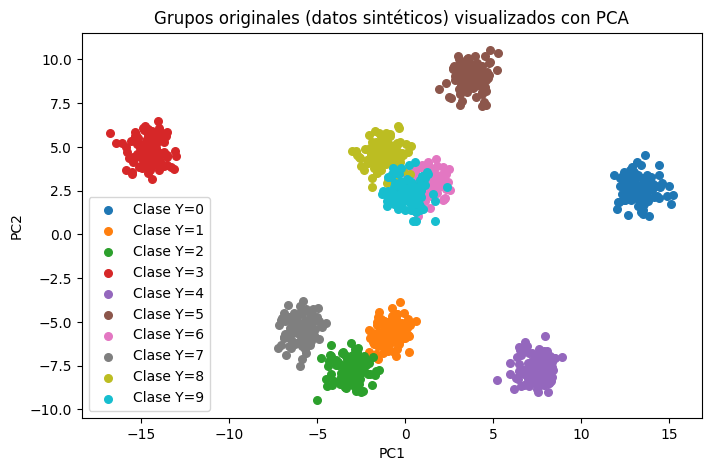

In [39]:
# Reducción a 2 dimensiones con PCA
p = PCA(n_components=2, random_state=0)
X2 = p.fit_transform(X)

# Visualización de los grupos originales
plt.figure(figsize=(8, 5))
for lab in np.unique(y):
    m = y == lab
    plt.scatter(X2[m, 0], X2[m, 1], s=30, label=f"Clase Y={lab}")
plt.title("Grupos originales (datos sintéticos) visualizados con PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


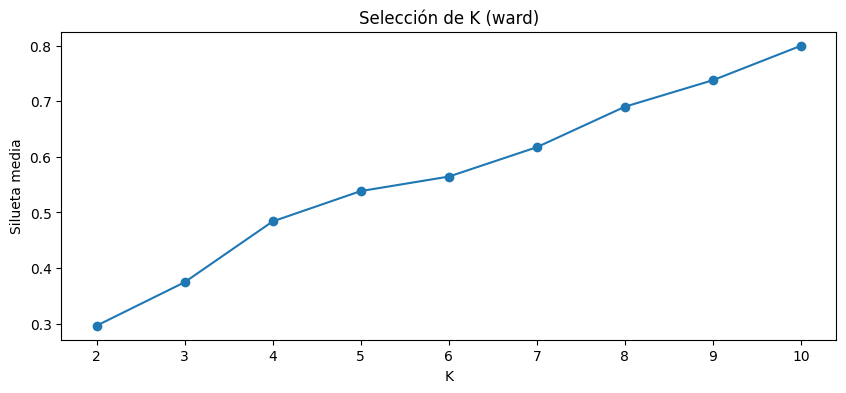

In [40]:
rango_k = range(2, 11)
vals_sil = []

for k in rango_k:
    mdl = AgglomerativeClustering(
        n_clusters=k,
        linkage="ward",
        metric="euclidean"
    )
    lab = mdl.fit_predict(X_scaled)
    vals_sil.append(silhouette_score(X_scaled, lab))

plt.figure(figsize=(10, 4))
plt.plot(list(rango_k), vals_sil, marker='o')
plt.xlabel("K"); plt.ylabel("Silueta media"); plt.title("Selección de K (ward)")
plt.show()

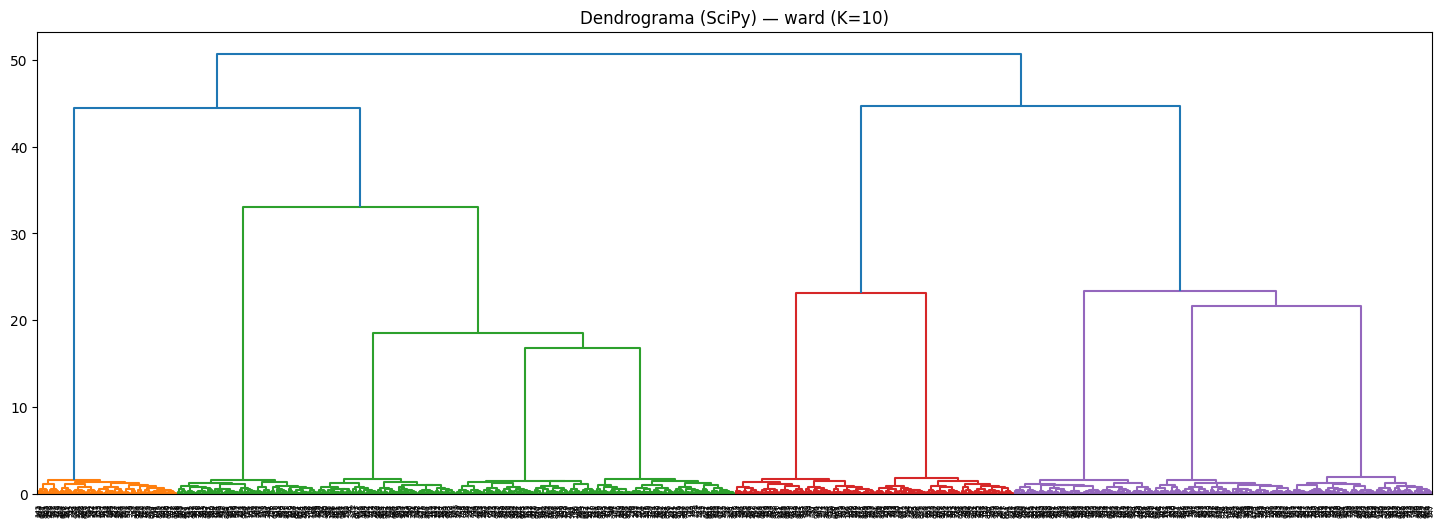

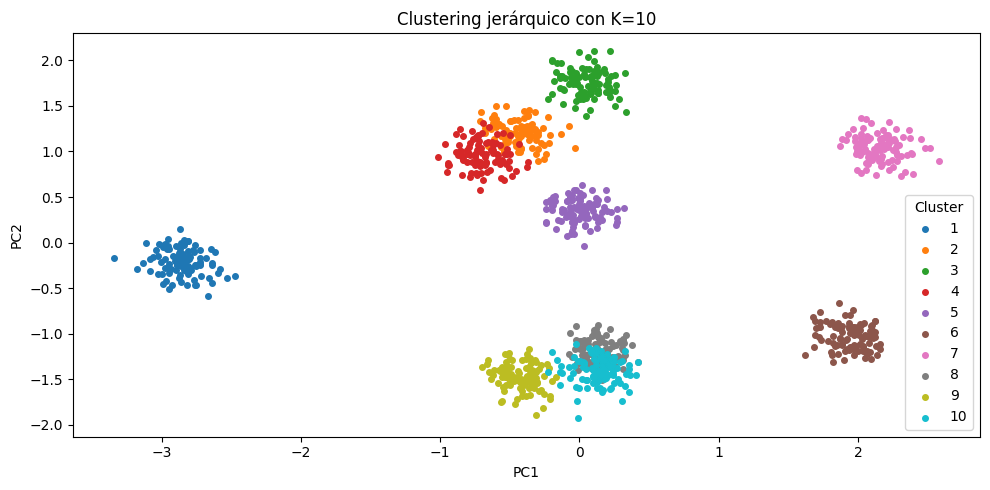

In [41]:
Z = linkage(X_scaled, method="ward", metric="euclidean")

#pedimos 10 clústeres:
K = 10
labels_h = fcluster(Z, t=K, criterion="maxclust")

plt.figure(figsize=(18, 6))
dendrogram(Z, color_threshold=None)
plt.title(f"Dendrograma (SciPy) — ward (K={K})")
plt.show()

# Visualización en 2D con PCA
pca_scatter_2d(X_scaled, labels_h, title=f"Clustering jerárquico con K={K}")

## Bisecting k-means

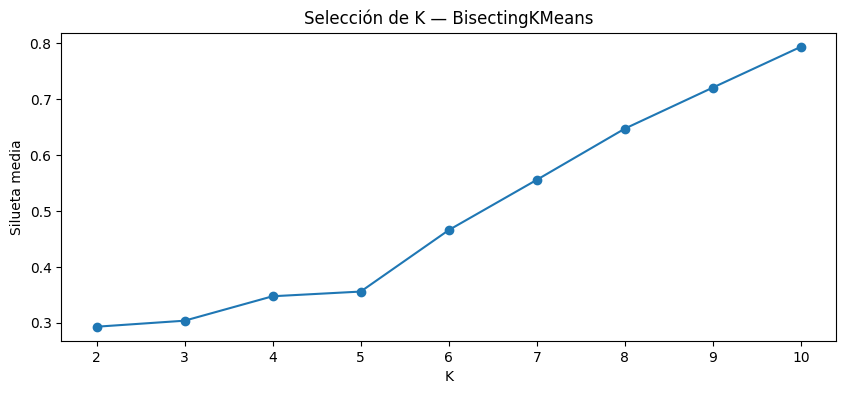

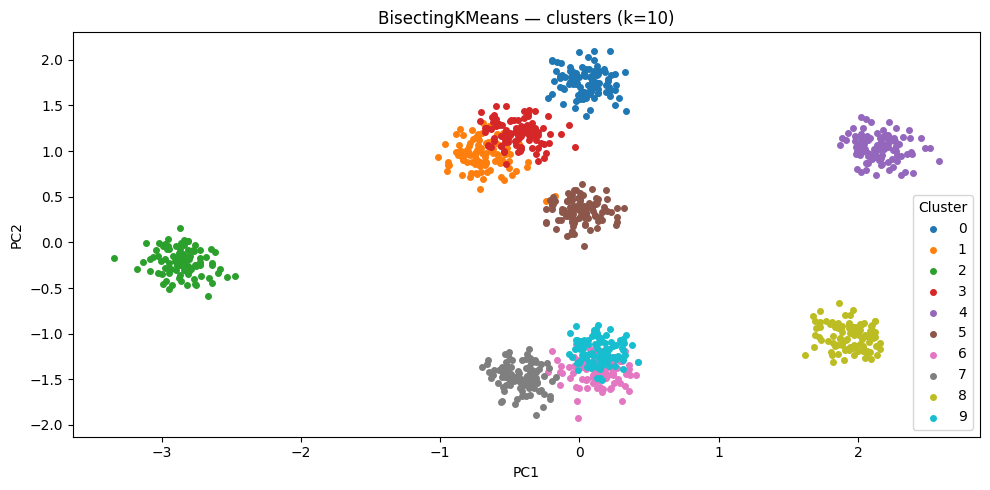

In [42]:
rango_k = range(2, 11)
vals_sil_bmk = []

for k in rango_k:
    bkm = BisectingKMeans(n_clusters=k, random_state=0)
    lab = bkm.fit_predict(X_scaled)
    vals_sil_bmk.append(silhouette_score(X_scaled, lab))

plt.figure(figsize=(10, 4))
plt.plot(list(rango_k), vals_sil_bmk, marker='o')
plt.xlabel("K"); plt.ylabel("Silueta media")
plt.title("Selección de K — BisectingKMeans")
plt.show()

k_bmk = int(np.argmax(vals_sil_bmk) + 2)
lab_bmk = BisectingKMeans(n_clusters=k_bmk, random_state=0).fit_predict(X_scaled)
pca_scatter_2d(X_scaled, lab_bmk, title=f"BisectingKMeans — clusters (k={k_bmk})")

## dbscan

In [43]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors

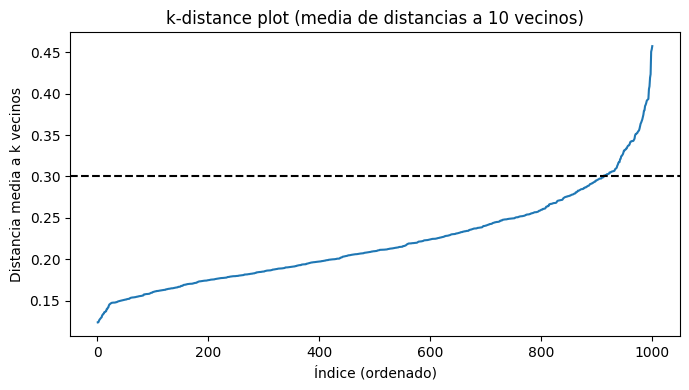

In [44]:
min_samples = 10

# Calculamos distancias a los k vecinos más cercanos
nbrs = NearestNeighbors(n_neighbors=min_samples + 1, algorithm="auto").fit(X_scaled)

distances, _ = nbrs.kneighbors(X_scaled)
mean_k_dist = distances[:, 1:].mean(axis=1)

# Ordenamos para el gráfico k-distance
kd_sorted = np.sort(mean_k_dist)

plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, len(kd_sorted) + 1), kd_sorted)
plt.title(f"k-distance plot (media de distancias a {min_samples} vecinos)")
plt.xlabel("Índice (ordenado)")
plt.ylabel("Distancia media a k vecinos")
plt.axhline(y=0.3, color="black", linestyle="--")
plt.tight_layout()
plt.show()

In [45]:
# Aplicamos DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X_scaled)
labels_db = db.labels_

# Número de clústeres detectados automáticamente
n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_ruido = np.sum(labels_db == -1)

print(f"Clústers encontrados (sin contar ruido): {n_clusters}")
print(f"Puntos etiquetados como ruido: {n_ruido}")

Clústers encontrados (sin contar ruido): 10
Puntos etiquetados como ruido: 25


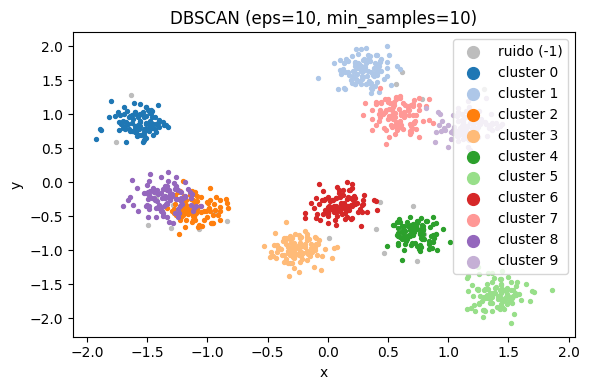

In [46]:
# Creamos DataFrame con los datos y etiquetas
df_plot = pd.DataFrame(X_scaled[:, :2], columns=["x", "y"])
df_plot["cluster"] = labels_db

# Plot
plt.figure(figsize=(6, 4))
palette = plt.colormaps["tab20"]

# Bucle que separa Ruido (-1) en gris, clusters con colores
for label, grupo in df_plot.groupby("cluster"):
    color = "#bdbdbd" if label == -1 else palette(label % 20)
    lbl = "ruido (-1)" if label == -1 else f"cluster {label}"
    plt.scatter(grupo["x"], grupo["y"], s=8, color=color, label=lbl)

plt.title("DBSCAN (eps=10, min_samples=10)")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(markerscale=3, loc="best", frameon=True)
plt.tight_layout()
plt.show()

**K-means**
El algoritmo K-means ha identificado 9 clústeres. Esto se debe a que dos grupos originales están muy próximos y el algoritmo, al basarse en distancias medias, los ha fusionado en uno solo. Aun así, los grupos formados son compactos y bien definidos.

**K-medoids**
K-medoids también ha detectado 9 clústeres, con una distribución casi idéntica a K-means. Al usar medoides (puntos reales) en lugar de medias, los centros permanecen estables incluso cuando se añaden outliers.

**Clustering jerárquico (aglomerativo)**
Usando el método Ward con K = 10, el modelo ha conseguido reproducir con precisión los 10 grupos originales. Las fronteras son claras y las distancias jerárquicas reflejan bien la estructura interna.

**Bisecting K-means**
El algoritmo divisivo de Bisecting K-means también ha identificado 10 clústeres bien diferenciados, equivalentes a los originales. Combina la rapidez de K-means con un proceso jerárquico que mejora la estabilidad de los resultados.

**DBSCAN**
Con los parámetros `eps=0.3` y `min_samples=10`, DBSCAN ha detectado 10 clústeres y unos pocos puntos de ruido, sin necesidad de fijar K. Su comportamiento se adapta bien a estos datos de densidad uniforme.

## Conclusión
Todos los métodos logran agrupar correctamente los datos, pero con pequeñas diferencias:

- **K-means** y **K-medoids** fusionan dos grupos cercanos (9 clústeres).
- **K-medoids** muestra una mayor robustez ante valores extremos y **DBSCAN** detecta automáticamente los puntos de ruido.

En conjunto, el método que ofrece los mejores resultados globales para estos datos bien separados es posiblemente **Bisecting K-means**, seguido de **clustering jerárquico** y **DBSCAN**.

# EJ 2)

In [47]:
# Carga y matriz X 
protein = pd.read_csv("protein.csv", index_col=0)
Xp = protein.values

# Escalado
scaler = StandardScaler()
Xp_scaled = scaler.fit_transform(Xp)

## K-means

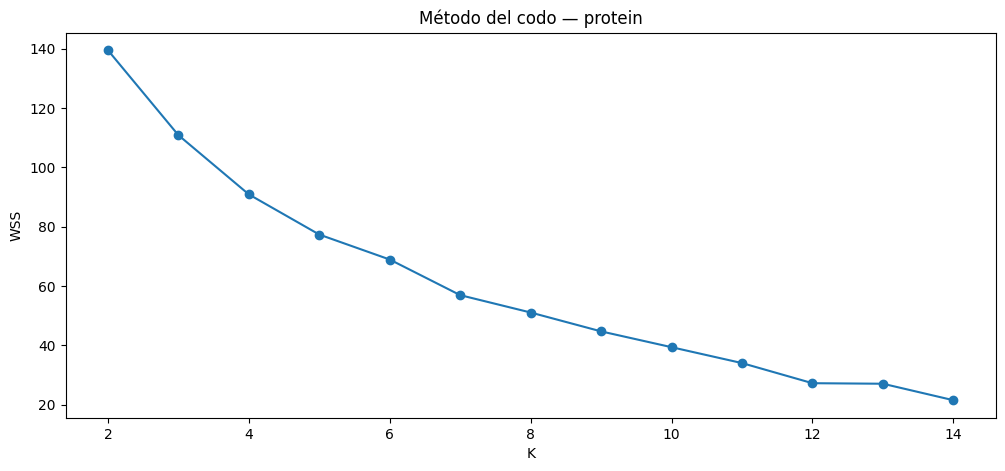

In [48]:
# Codo
wss = []
rango_prueba = range(2, 15)
for K in rango_prueba:
    clf = KMeans(init="random", random_state=0, n_clusters=K)
    clf.fit(Xp_scaled)
    wss.append(clf.inertia_)

plt.figure(figsize=(12,5))
plt.plot(list(rango_prueba), wss, marker='o')
plt.xlabel("K"); plt.ylabel("WSS"); plt.title("Método del codo — protein")
plt.show()

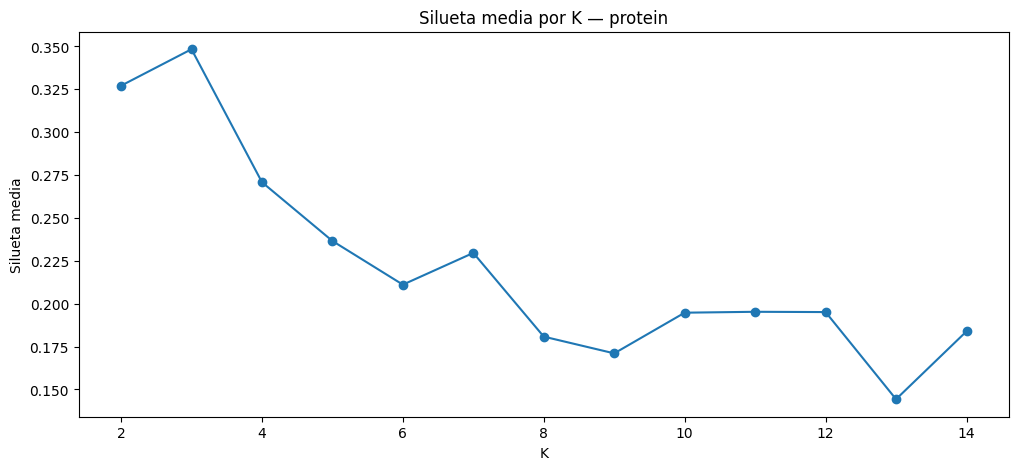

In [49]:
# cálculo de la silueta media
valores_silueta_media = []
for K in rango_prueba:
    clf = KMeans(init="random", random_state=0, n_clusters=K)
    labels = clf.fit_predict(Xp_scaled)
    valores_silueta_media.append(silhouette_score(Xp_scaled, labels))

plt.figure(figsize=(12,5))
plt.plot(list(rango_prueba), valores_silueta_media, marker='o')
plt.xlabel("K"); plt.ylabel("Silueta media"); plt.title("Silueta media por K — protein")
plt.show()


Tanto el método del codo como la silueta media apuntan a K = 3 como el valor más adecuado sin saber los grupos reales

In [50]:
K_opt = 3
clf = KMeans(init="random", random_state=0, n_clusters=K_opt)
clf.fit(Xp_scaled)
labels = clf.labels_

C:\Users\Alberto\AppData\Local\Temp\ipykernel_17724\213965300.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap("tab10")


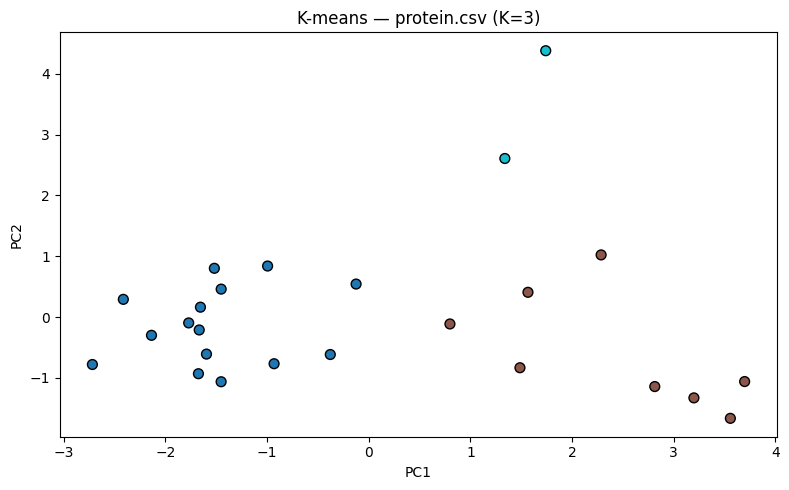

In [51]:
# Reducción a 2D con PCA
p = PCA(n_components=2, random_state=0)
Xp2 = p.fit_transform(Xp_scaled)

# Gráfico con colores visibles
plt.figure(figsize=(8, 5))
palette = plt.cm.get_cmap("tab10")
plt.scatter(Xp2[:, 0], Xp2[:, 1], c=clf.labels_, cmap=palette, s=50, edgecolor='k')
plt.title(f"K-means — protein.csv (K={K_opt})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

## Agglomerative clustering

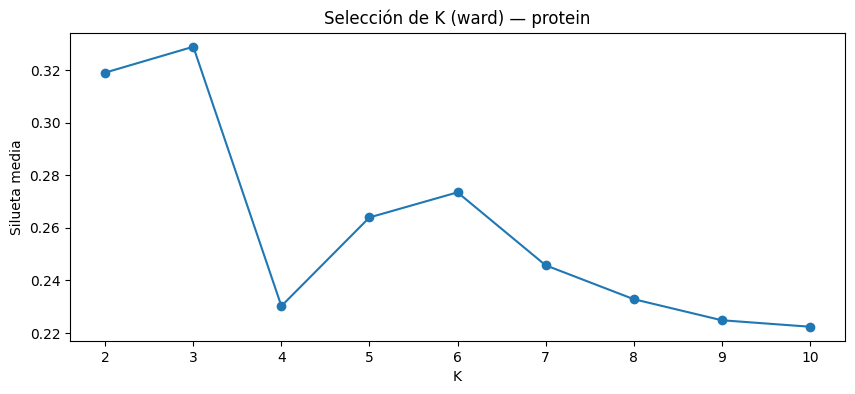

In [52]:
# Selección de K por silueta (ward)
rango_k = range(2, 11)
vals_sil = []

for k in rango_k:
    mdl = AgglomerativeClustering(
        n_clusters=k,
        linkage="ward",
        metric="euclidean"
    )
    lab = mdl.fit_predict(Xp_scaled)
    vals_sil.append(silhouette_score(Xp_scaled, lab))

plt.figure(figsize=(10, 4))
plt.plot(list(rango_k), vals_sil, marker='o')
plt.xlabel("K"); plt.ylabel("Silueta media"); plt.title("Selección de K (ward) — protein")
plt.show()


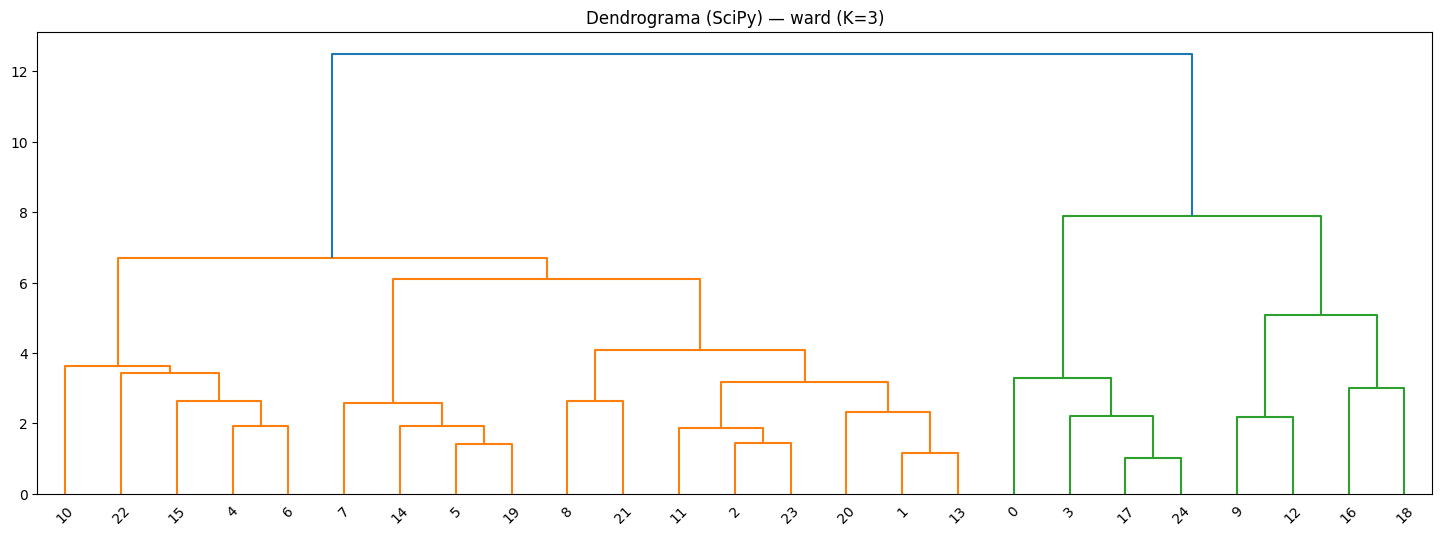

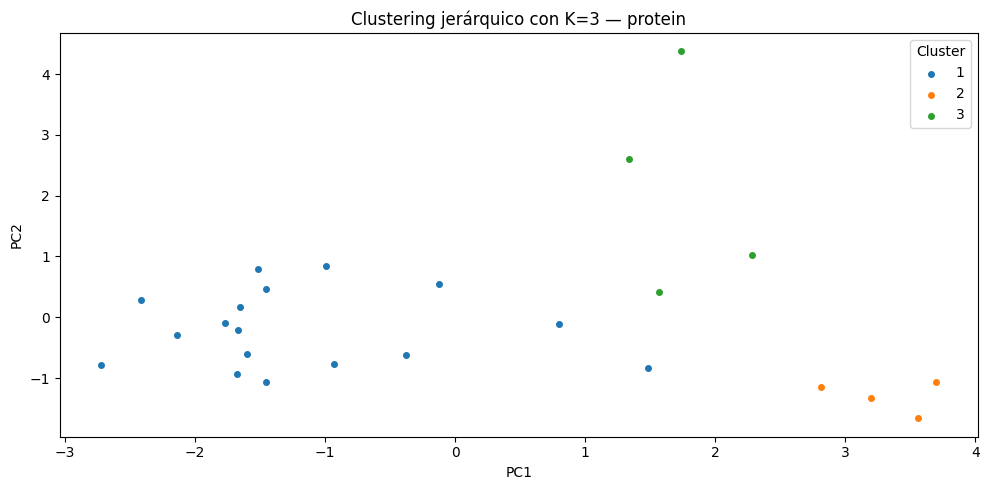

In [53]:
# Dendrograma y corte por K
Z = linkage(Xp_scaled, method="ward", metric="euclidean")
K = 3
labels_h = fcluster(Z, t=K, criterion="maxclust")

plt.figure(figsize=(18, 6))
dendrogram(Z, color_threshold=None)
plt.title(f"Dendrograma (SciPy) — ward (K={K})")
plt.show()

# Visualización 2D con PCA
pca_scatter_2d(Xp_scaled, labels_h, title=f"Clustering jerárquico con K={K} — protein")

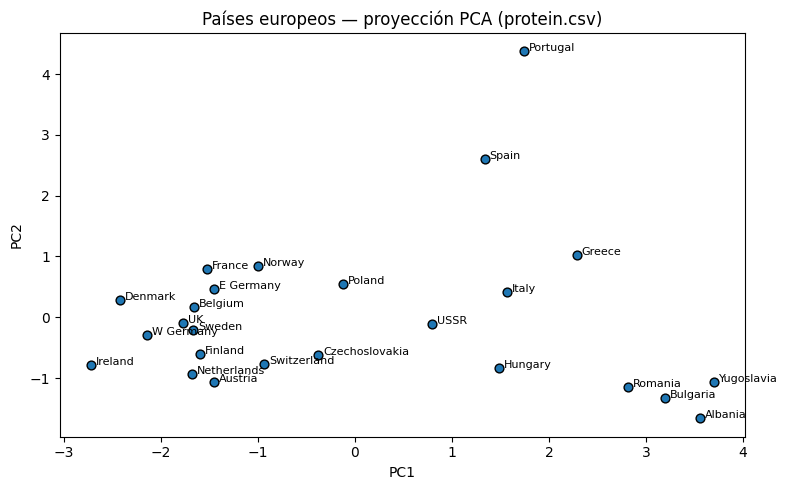

In [54]:
# Reducción a 2 dimensiones con PCA
p = PCA(n_components=2, random_state=0)
Xp2 = p.fit_transform(Xp_scaled)

# Visualización de los países según sus dos primeras componentes principales
plt.figure(figsize=(8, 5))
plt.scatter(Xp2[:, 0], Xp2[:, 1], s=40, edgecolor='k')
for i, country in enumerate(protein.index):
    plt.text(Xp2[i, 0] + 0.05, Xp2[i, 1], country, fontsize=8)

plt.title("Países europeos — proyección PCA (protein.csv)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


## Conclusiones

El análisis con PCA muestra que los países europeos se agrupan de forma natural en tres grandes zonas.

Con K-means y el clustering jerárquico (Ward) el número óptimo de grupos es K=3. Ambos métodos forman clústeres similares, que separan a los países del norte y centro de Europa de los del sur y del este.

*Posibles explicaciones*:  
El primer grupo reúne países con un consumo elevado de productos animales (norte y centro de Europa).  
El segundo grupo incluye países mediterráneos con consumo medio.  
El tercero agrupa países del este y sureste con menor consumo de proteínas y mayor dependencia de cereales.

Los dos métodos ofrecen resultados coherentes y estables; el jerárquico permite visualizar mejor las relaciones entre grupos y el K-means es más directo para clasificar los países.
